In [1]:
import numpy as np
from scipy import sparse
import scipy.stats as stats
import random
from collections import defaultdict, namedtuple
from os import listdir
import json
import matplotlib.pyplot as plt
import gzip

In [2]:
build = '38'

#data_dir = '../../DATA/spark/genotypes'
#phase_dir = '../../PhasingFamilies/phased_spark_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/spark_quads_identicals.txt'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'

#data_dirs = ['../../DATA/ihart.ms2/genotypes', 
#             '../../DATA/mssng/genotypes']
#phase_dirs = ['../../PhasingFamilies/phased_ihart.ms2_quads', 
#              '../../PhasingFamilies/phased_mssng_quads']
#identicals_files = ['../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt',
#                    '../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt']
#ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped',
#             '../../DATA/mssng/mssng.ped.quads.ped']

#data_dirs = ['../../DATA/ihart.ms2/genotypes']
#phase_dirs = ['../../PhasingFamilies/phased_ihart.ms2_quads']
#identicals_files = ['../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt']
#ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped']

data_dirs = ['../../DATA/mssng/genotypes']
phase_dirs = ['../../PhasingFamilies/phased_mssng_quads']
identicals_files = ['../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt']
ped_files = ['../../DATA/mssng/mssng.ped.quads.ped']


#data_dirs = ['../../DATA/ssc.hg38/genotypes/phase1-1', 
#             '../../DATA/ssc.hg38/genotypes/phase1-2',
#             '../../DATA/ssc.hg38/genotypes/phase1-3',
#             '../../DATA/ssc.hg38/genotypes/phase1-4',
#             '../../DATA/ssc.hg38/genotypes/phase1-5',
#             '../../DATA/ssc.hg38/genotypes/phase1-7',
#             '../../DATA/ssc.hg38/genotypes/phase2',
#             '../../DATA/ssc.hg38/genotypes/phase2_B01',
#             '../../DATA/ssc.hg38/genotypes/phase2_Replacements',
#             '../../DATA/ssc.hg38/genotypes/phase3_1',
#             '../../DATA/ssc.hg38/genotypes/phase3_1_B02',
#             '../../DATA/ssc.hg38/genotypes/phase3_2',
#             '../../DATA/ssc.hg38/genotypes/phase4',
#             '../../DATA/ssc.hg38/genotypes/pilot',
#            ]
#phase_dirs = ['../../PhasingFamilies/phased_ssc.hg38']*14
#identicals_files = ['../../PhasingFamilies/sibpair_similarity/ssc.hg38_identicals.txt']*14
#ped_files = ['../../DATA/ssc.hg38/ssc.ped']*14

In [18]:

chrom = '10'
if build == '37':
    start_pos, end_pos = 127188569, 128188569
    chrom_length = 135534747
elif build == '38':
    #start_pos, end_pos = 125500000, 126500000
    #start_pos, end_pos = 125894783, 125905304
    start_pos, end_pos = 125050581, 126917556
    chrom_length = 133797422


In [19]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	print('males', len([x for x in sample_to_sex.values() if x=='1']), 'females', len([x for x in sample_to_sex.values() if x=='2']))
	print('unaffected', len([x for x in sample_to_affected.values() if x=='1']), 
		'affected', len([x for x in sample_to_affected.values() if x=='2']))
	return sample_to_affected, sample_to_sex



In [20]:
Trio = namedtuple('Trio', ['family', 'child', 'mom', 'dad', 'phase_dir', 'is_affected', 'is_male'])
def pull_trios(phase_dir, identicals_file, sample_to_affected, sample_to_sex):

    # pull identicals
    leave_out = set()
    with open(identicals_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            leave_out.update(pieces[1:])

    # pull individuals
    family_to_inds = defaultdict(list)
    trios = list()
    for filename in listdir(phase_dir):
        if filename.endswith('.phased.txt'):
            family_key = filename[:-11]
            try:
                with open('%s/%s' % (phase_dir, filename), 'r')  as f:
                    header = next(f).strip().split('\t')
                    # check that we have a typical nuclear family structure
                    if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
                        individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
                        family_to_inds[family_key] = individuals
                        for child in individuals[2:]:
                            if child not in leave_out and child in sample_to_affected:
                                trios.append(Trio(family_key, child, individuals[0], individuals[1], 
                                    phase_dir,
                                    sample_to_affected[child]=='2',
                                    sample_to_sex[child]=='1'))
                                leave_out.add(child)
            except StopIteration:
                pass

    trios = sorted(trios)

    assert len(trios) == len(set(trios)) # should have no duplicates
    return family_to_inds, trios



In [21]:
def pull_data(data_dir, phase_dir, identicals_file, ped_file):

    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
    variant_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.variants.txt.gz' in f], key=lambda x: int(x.split('.')[2]))
    coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
    sample_file = '%s/samples.json' % data_dir

    print(len(gen_files), len(coord_files))
    assert len(gen_files) == len(coord_files)
    assert len(gen_files) == len(variant_files)
    
    # pull samples
    with open(sample_file, 'r') as f:
        sample_ids = json.load(f)
    sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

    
    # pull coordinates
    # use only SNPs, no indels
    # use only variants that PASS GATK
    # pull data only for individuals

    gens, snp_positions = [], []
    refs, alts = [], []
    total_pos = 0
    for gen_file, var_file, coord_file in zip(gen_files, variant_files, coord_files):
        coords = np.load('%s/%s' % (data_dir, coord_file))

        if coords.shape[0]>0:
            poss = coords[:, 1]
            is_snp = coords[:, 2]==1
            is_pass = coords[:, 3]==1

            in_interval = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos)

            if np.sum(is_snp & is_pass & in_interval)>0:
                gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))
                total_pos += np.sum(is_snp & is_pass)
                has_data = np.where(is_snp & is_pass & in_interval)[0]

                gens.append(gen[:, has_data].A)
                snp_positions.append(poss[has_data])
                
                with gzip.open('%s/%s' % (data_dir, var_file), 'rt') as f:
                    for line, inc, p in zip(f, is_snp & is_pass & in_interval, poss):
                        if inc:
                            pieces = line.strip().split('\t', maxsplit=5)
                            assert int(pieces[1])==p
                            refs.append(pieces[3])
                            alts.append(pieces[4])
                            
                    

    gens = np.hstack(gens)
    snp_positions = np.hstack(snp_positions)
    print(gens.shape, snp_positions.shape)

    assert np.all(snp_positions <= chrom_length)


    # remove multiallelic sites
    is_multiallelic = np.zeros((snp_positions.shape[0],), dtype=bool)
    indices = np.where(snp_positions[:-1] == snp_positions[1:])[0]
    is_multiallelic[indices] = True
    is_multiallelic[indices+1] = True
    print(np.sum(is_multiallelic))

    gens = gens[:, ~is_multiallelic & (snp_positions>=start_pos) & (snp_positions<=end_pos)]
    snp_positions = snp_positions[~is_multiallelic & (snp_positions>=start_pos) & (snp_positions<=end_pos)]
    refs = [refs[i] for i in np.where(~is_multiallelic & (snp_positions>=start_pos) & (snp_positions<=end_pos))[0]]
    alts = [alts[i] for i in np.where(~is_multiallelic & (snp_positions>=start_pos) & (snp_positions<=end_pos))[0]]
    
    sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)
    family_to_inds, trios = pull_trios(phase_dir, identicals_file, sample_to_affected, sample_to_sex)
    trios = [trio for trio in trios if trio.mom in sample_id_to_index and trio.dad in sample_id_to_index and trio.child in sample_id_to_index]
    
    
    trio_indices = np.array([[sample_id_to_index[trio.mom], sample_id_to_index[trio.dad], sample_id_to_index[trio.child]] for trio in trios])
    is_affected = np.array([trio.is_affected for trio in trios])
    is_male = np.array([trio.is_male for trio in trios])
    print(trio_indices.shape, np.sum(is_affected), np.sum(is_male))
    
    trio_gen = gens[trio_indices, :]
    return trio_gen, snp_positions, is_affected, is_male, [trio.child for trio in trios], refs, alts



trio_gens, snp_positions, is_affecteds, is_males = [], [], [], []
already_included = set()
all_samples = []
refss, altss = [], []
for data_dir, phase_dir, identicals_file, ped_file in zip(data_dirs, phase_dirs, identicals_files, ped_files):
    trio_gen, snp_position, is_affected, is_male, samples, refs, alts = pull_data(data_dir, phase_dir, identicals_file, ped_file)
    to_include = np.array([x not in already_included for x in samples])
    print(trio_gen.shape, snp_position.shape, is_affected.shape)
    print('including', np.sum(to_include), 'of', len(to_include))
    
    trio_gens.append(trio_gen[to_include, :, :])
    snp_positions.append(snp_position)
    is_affecteds.append(is_affected[to_include])
    is_males.append(is_male[to_include])
    already_included.update([x for inc, x in zip(to_include, samples) if inc])
    all_samples.extend([x for inc, x in zip(to_include, samples) if inc])
    refss.append(refs)
    altss.append(alts)

14 14
(9621, 92136) (92136,)
0
males 863 females 330
unaffected 182 affected 968
(1094, 3) 888 777
(1094, 3, 92136) (92136,) (1094,)
including 1094 of 1094


In [22]:
all_snp_positions = []
indices = np.zeros((len(snp_positions),), dtype=int)

while np.any([i < len(pos) for i, pos in zip(indices, snp_positions)]):
    #print(indices, [len(x) for x in snp_positions])
    next_up = [(pos[i], j) for j, (i, pos) in enumerate(zip(indices, snp_positions)) if i < len(pos)  ]
    min_value, min_index = min(next_up, key=lambda x: x[0])
    
    if len(all_snp_positions)==0 or all_snp_positions[-1] != min_value:
        all_snp_positions.append(min_value)
    indices[min_index] += 1
print(len(all_snp_positions))


92136


In [23]:
# can't merge unless refs and alts all match
snp_position_to_alleles = defaultdict(set)
for pos, ref, alt in zip(snp_positions, refss, altss):
    assert len(pos) == len(ref)
    assert len(pos) == len(alt)
    for p, r, a in zip(pos, ref, alt):
        snp_position_to_alleles[p].add((r, a))
        
for pos, alleles in snp_position_to_alleles.items():
    if len(alleles)>1:
        print(pos, alleles)
all_snp_positions = [x for x in all_snp_positions if len(snp_position_to_alleles[x])==1]
print(len(all_snp_positions))
snp_position_to_index = dict([(x, i) for i, x in enumerate(all_snp_positions)])

92136


In [24]:
all_trio_gens = []
for trio_gen, snp_position in zip(trio_gens, snp_positions):
    new_data = -np.ones((trio_gen.shape[0], 3, len(all_snp_positions)))
    ok_index = np.array([x in snp_position_to_index for x in snp_position])
    new_data[:, :, [snp_position_to_index[x] for x in snp_position[ok_index]]] = trio_gen[:, :, ok_index]
    all_trio_gens.append(new_data)
    
all_trio_gens = np.vstack(all_trio_gens)

In [25]:
trio_gen = all_trio_gens
is_affected = np.hstack(is_affecteds)
is_male = np.hstack(is_males)

snp_positions = np.array(all_snp_positions)
print(trio_gen.shape, is_affected.shape, snp_positions.shape)

(1094, 3, 92136) (1094,) (92136,)


In [26]:
print(np.sum(is_affected), np.sum(is_male))

888 777


In [27]:
def genomic_inflation_plot(pvalues, binsize=.1):
    # expects numpy array of pvalues
    plt.figure(figsize=(7, 5))
    indices = ~np.isnan(pvalues) #& np.all(np.sum(all_allele_counts, axis=1)>100, axis=1)
    a = np.power(10.0, -np.arange(12, -binsize, -binsize))
    # hist
    ax = plt.subplot(1, 1, 1)
    n, bins, _ = plt.hist(np.clip(pvalues[indices], 10.0**(-20), None), 
                          bins=a, log=True, color='#4db6ac')
    # theoretical - expect pvalues to follow a uniform distribution between 0-1
    exp = np.sum(indices)*(bins[1:]-bins[:-1])
    plt.plot(10**(binsize/2) * a[:-1][exp>1], exp[exp>1], color='black', linestyle='--', linewidth=2, label='theoretical')
    plt.xlabel('pvalue')
    plt.ylabel('Number of Sites')
    plt.title('Histogram of pvalues')
    plt.xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.axvline(0.05/pvalues.shape[0], color='darkred', linestyle='--', linewidth='2', label='bonferonni')
    plt.legend()
    plt.tight_layout()
    plt.show()


# unusual transmission pattern

In [28]:
# variant, parent gens 00/01/02/11/12/22, child gen 0/1/2/-1
pvalues_trans = np.ones((trio_gen.shape[2], 6, 4))
num_tests = 0

for i, parental_gens in enumerate([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]):
    parents_match = ((trio_gen[:, 0, :]==parental_gens[0]) & (trio_gen[:, 1, :]==parental_gens[1])) | ((trio_gen[:, 1, :]==parental_gens[0]) & (trio_gen[:, 0, :]==parental_gens[1]))

    for j, child_gen in enumerate([0, 1, 2]):
        print(parental_gens, child_gen)

        child_matches = trio_gen[:, 2, :]==child_gen
        a = np.sum(parents_match[is_affected, :] & child_matches[is_affected, :], axis=0)
        b = np.sum(parents_match[is_affected, :] & ~child_matches[is_affected, :], axis=0)
        c = np.sum(parents_match[~is_affected, :] & child_matches[~is_affected, :], axis=0)
        d = np.sum(parents_match[~is_affected, :] & ~child_matches[~is_affected, :], axis=0)

        for k in np.where((a>5) & (b>5) & (c>5) & (d>5))[0]:
            try:
                pvalues_trans[k, i, j] = stats.chi2_contingency([[a[k], b[k]], [c[k], d[k]]])[1]
                num_tests += 1
            except:
                pass


(0, 0) 0
(0, 0) 1
(0, 0) 2
(0, 1) 0
(0, 1) 1
(0, 1) 2
(0, 2) 0
(0, 2) 1
(0, 2) 2
(1, 1) 0
(1, 1) 1
(1, 1) 2
(1, 2) 0
(1, 2) 1
(1, 2) 2
(2, 2) 0
(2, 2) 1
(2, 2) 2


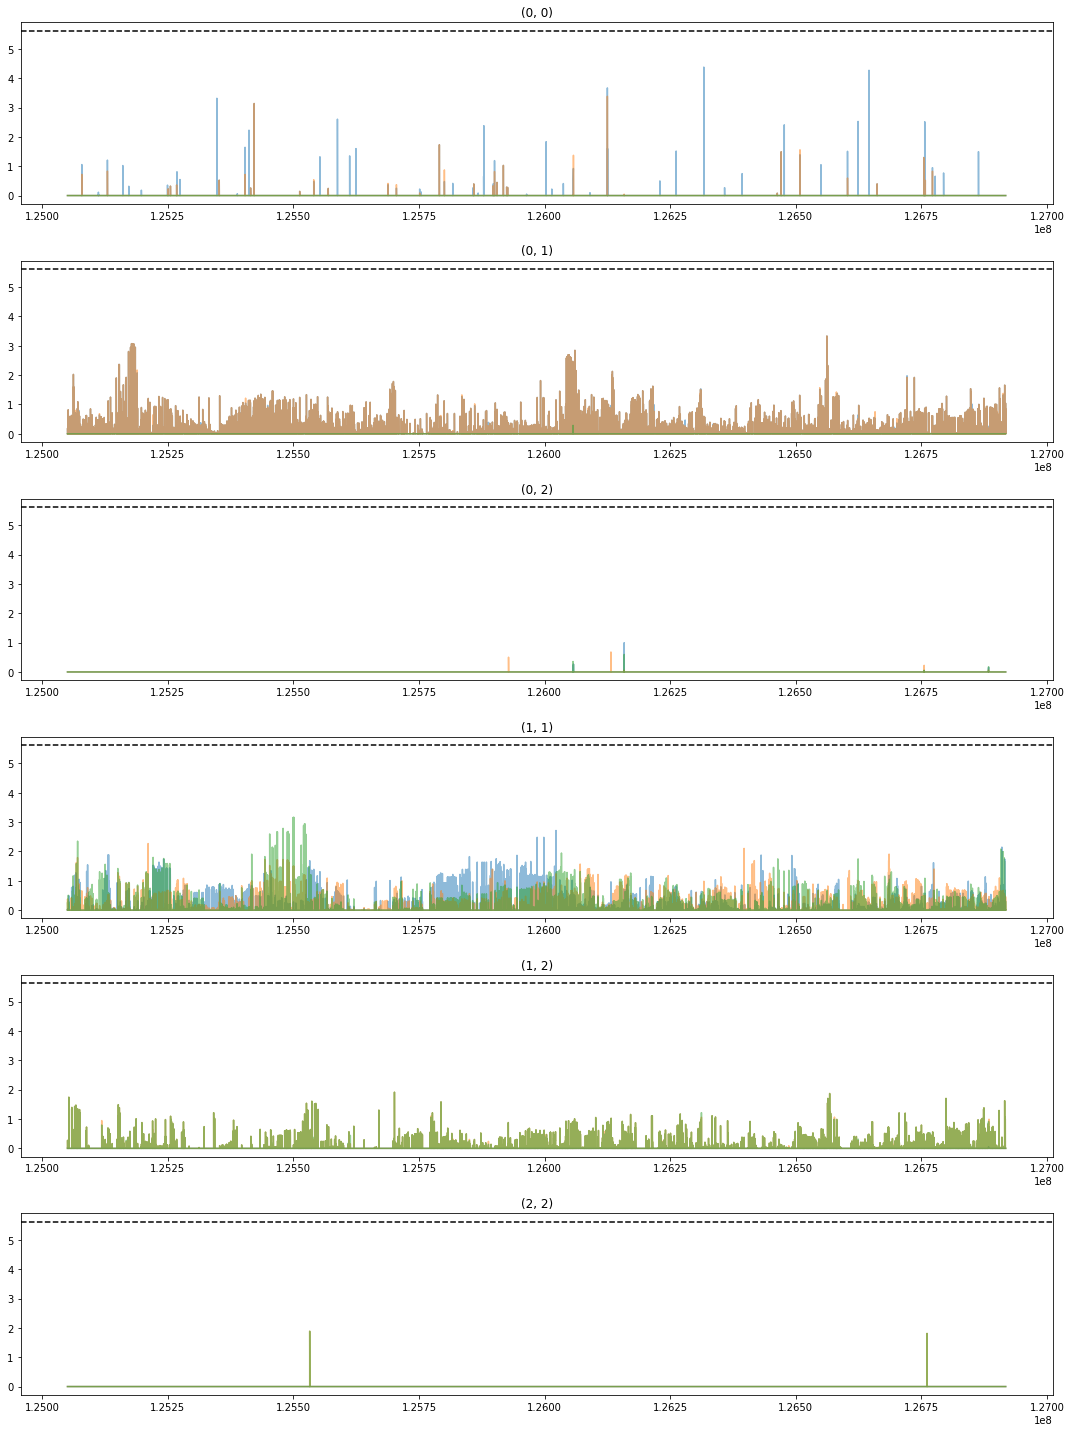

In [29]:
plt.figure(figsize=(15, 20))

for i, pg in enumerate([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]):
    plt.subplot(6, 1, i+1)
    for j in range(3):
        plt.plot(snp_positions, -np.log10(pvalues_trans[:, i, j]), alpha=0.5)
        plt.title(pg)
    plt.axhline(-np.log10(0.05/num_tests), color='black', linestyle='--')
    
plt.tight_layout()
plt.show()

In [30]:
print(np.where(-np.log10(pvalues_trans)>4.5))
print(snp_positions[11981])

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
125274839


In [16]:
index = np.where(snp_positions==125790607)[0]

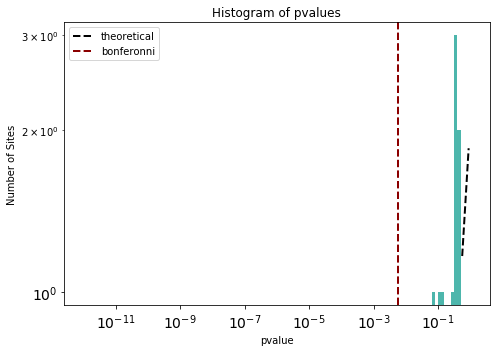

In [17]:
genomic_inflation_plot(pvalues_trans[:, 0, :][pvalues_trans[:, 0, :]!=1].flatten())

In [416]:
np.sum(is_male), np.sum(~is_male)

(2973, 1338)

In [417]:
parents_match = (trio_gen[:, 0, index]==0) & (trio_gen[:, 1, index]==0)
aff_count, unaff_count = [0]*4, [0]*4

for j, child_gen in enumerate([0, 1, 2, -1]):
    print(child_gen)
    child_matches = (trio_gen[:, 2, index]==child_gen)
    aff_count[j] = np.sum(parents_match[is_affected] & child_matches[is_affected])
    unaff_count[j] = np.sum(parents_match[~is_affected] & child_matches[~is_affected])
    
    try:
        print(stats.chi2_contingency([[np.sum(parents_match[is_male] & child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & child_matches[~is_male])],
                                 [np.sum(parents_match[is_male] & ~child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & ~child_matches[~is_male])]])[1])
        print(stats.chi2_contingency([[np.sum(parents_match[is_affected] & child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & child_matches[~is_affected])],
                                 [np.sum(parents_match[is_affected] & ~child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & ~child_matches[~is_affected])]])[1])
    except:
        pass
    
print(np.array(aff_count))
print(np.array(unaff_count))

print(np.array(aff_count)/sum(aff_count))
print(np.array(unaff_count)/sum(unaff_count))

# [1452   80    0    0]
# [341  18   0   0]
# [0.94778068 0.05221932 0.         0.        ]
# [0.94986072 0.05013928 0.         0.        ]

#[895 203   0   0]
#[662 195   0   0]
#[0.8151184 0.1848816 0.        0.       ]
#[0.77246208 0.22753792 0.         0.        ]

#male
#[785 173   0   0]
#[319  93   0   0]
#[0.81941545 0.18058455 0.         0.        ]
#[0.77427184 0.22572816 0.         0.        ]

# female
#[110  30   0   0]
#[343 102   0   0]
#[0.78571429 0.21428571 0.         0.        ]
#[0.77078652 0.22921348 0.         0.        ]

0
0.12333136212451638
1.7861148595522203e-05
1
0.12333136212451638
1.7861148595522203e-05
2
-1
[1109  217    0    0]
[704 219   0   0]
[0.83634992 0.16365008 0.         0.        ]
[0.76273023 0.23726977 0.         0.        ]


In [419]:
parents_match = ((trio_gen[:, 0, index]==0) & (trio_gen[:, 1, index]==1)) | ((trio_gen[:, 0, index]==1) & (trio_gen[:, 1, index]==0))
aff_count, unaff_count = [0]*4, [0]*4

for j, child_gen in enumerate([0, 1, 2, -1]):

    child_matches = trio_gen[:, 2, index]==child_gen
    aff_count[j] = np.sum(parents_match[is_affected] & child_matches[is_affected])
    unaff_count[j] = np.sum(parents_match[~is_affected] & child_matches[~is_affected])
    
    try:
        print(stats.chi2_contingency([[np.sum(parents_match[is_male] & child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & child_matches[~is_male])],
                                 [np.sum(parents_match[is_male] & ~child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & ~child_matches[~is_male])]])[1])
        print(stats.chi2_contingency([[np.sum(parents_match[is_affected] & child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & child_matches[~is_affected])],
                                 [np.sum(parents_match[is_affected] & ~child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & ~child_matches[~is_affected])]])[1])
    except:
        pass
    
print(np.array(aff_count))
print(np.array(unaff_count))

print(np.array(aff_count)/sum(aff_count))
print(np.array(unaff_count)/sum(unaff_count))

# [200  12   0   0]
# [45  5  0  0]
# [0.94339623 0.05660377 0.         0.        ]
# [0.9 0.1 0.  0. ]

0.9670944183091087
0.28135788449903465
0.9670944183091087
0.28135788449903465
[461 297   0   0]
[449 256   0   0]
[0.60817942 0.39182058 0.         0.        ]
[0.63687943 0.36312057 0.         0.        ]


In [420]:
parents_match = (trio_gen[:, 0, index]==1) & (trio_gen[:, 1, index]==1)
aff_count, unaff_count = [0]*4, [0]*4

for j, child_gen in enumerate([0, 1, 2, -1]):

    child_matches = trio_gen[:, 2, index]==child_gen
    aff_count[j] = np.sum(parents_match[is_affected] & child_matches[is_affected])
    unaff_count[j] = np.sum(parents_match[~is_affected] & child_matches[~is_affected])
    
    try:
        print(stats.chi2_contingency([[np.sum(parents_match[is_male] & child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & child_matches[~is_male])],
                                 [np.sum(parents_match[is_male] & ~child_matches[is_male]),
                                  np.sum(parents_match[~is_male] & ~child_matches[~is_male])]])[1])
        print(stats.chi2_contingency([[np.sum(parents_match[is_affected] & child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & child_matches[~is_affected])],
                                 [np.sum(parents_match[is_affected] & ~child_matches[is_affected]),
                                  np.sum(parents_match[~is_affected] & ~child_matches[~is_affected])]])[1])
    except:
        pass
    
print(np.array(aff_count))
print(np.array(unaff_count))

print(np.array(aff_count)/sum(aff_count))
print(np.array(unaff_count)/sum(unaff_count))

# [15  4  0  0]
# [5 0 0 0]
# [0.78947368 0.21052632 0.         0.        ]
# [1. 0. 0. 0.]

0.9492520174869145
0.5061122745785371
0.9492520174869145
0.5061122745785371
[133 122   0   0]
[123 129   0   0]
[0.52156863 0.47843137 0.         0.        ]
[0.48809524 0.51190476 0.         0.        ]


In [346]:
np.sum((trio_gen[:, 0, index]==0) & (trio_gen[:, 1, index]==0) & (trio_gen[:, 2, index]==1))

# 98

398